In [107]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

Populating the interactive namespace from numpy and matplotlib


In [108]:
results = pd.read_csv('BC_final_results.csv', index_col=0)
ms_results = pd.read_csv('BC_MS_results.csv', index_col=0)
sample_info = pd.read_csv('BC_sample_info.csv', index_col=0)

results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)
ms_results['pval'] = ms_results['pval'].clip_lower(ms_results.query('pval > 0')['pval'].min() / 2)
ms_results['qval'] = ms_results['qval'].clip_lower(ms_results.query('qval > 0')['qval'].min() / 2)

In [109]:
df = pd.read_table('data/Layer2_BC_count_matrix-1.tsv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

df = df[results.g]  # Order like in results

dfm = np.log10(df + 1)

In [110]:
def xpercent_scale():
    gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in gca().get_xticks()])

In [111]:
from matplotlib.colors import LogNorm

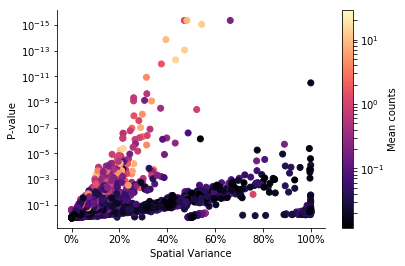

In [117]:
plt.yscale('log')
plt.scatter(results.fraction_spatial_variance, results.pval,
            c=df.mean(),
            norm=LogNorm(),
            cmap=cm.magma,
            rasterized=True);

plt.gca().invert_yaxis();

xpercent_scale()
plt.xlabel('Spatial Variance')
plt.ylabel('P-value');
plt.colorbar(label='Mean counts');

plt.savefig('significane-mean-counts.pdf')

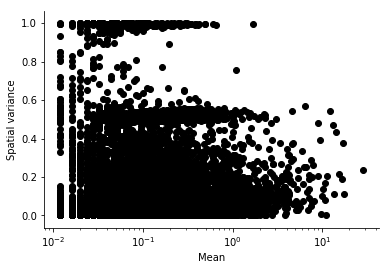

In [118]:
plt.xscale('log')
plt.scatter(df.mean(), results.fraction_spatial_variance, c='k', rasterized=True);

plt.xlabel('Mean')
plt.ylabel('Spatial variance');

plt.savefig('mean-fsv.pdf')

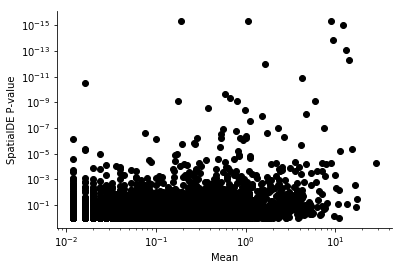

In [119]:
plt.xscale('log')
plt.yscale('log')
plt.scatter(df.mean(), results.pval, c='k', rasterized=True);
plt.gca().invert_yaxis();
plt.xlabel('Mean');
plt.ylabel('SpatialDE P-value');

plt.savefig('mean-pval.pdf')

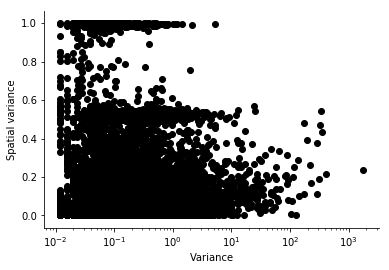

In [120]:
plt.xscale('log')
plt.scatter(df.var(), results.fraction_spatial_variance, c='k', rasterized=True);
plt.xlabel('Variance');
plt.ylabel('Spatial variance');

plt.savefig('var-fsv.pdf')

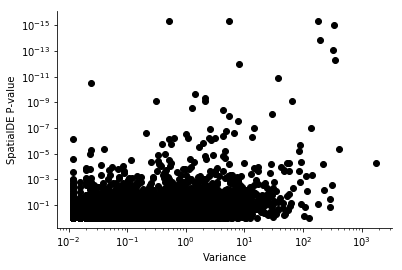

In [122]:
plt.xscale('log')
plt.yscale('log')
plt.scatter(df.var(), results.pval, c='k', rasterized=True);
plt.xlabel('Variance');
plt.ylabel('SpatialDE P-value')
plt.gca().invert_yaxis();

plt.savefig('var-pval.pdf')

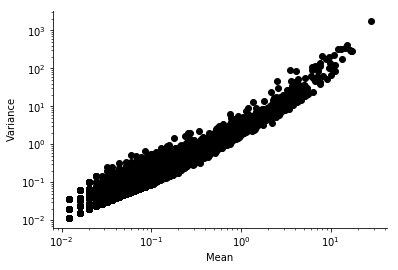

In [123]:
plt.xscale('log')
plt.yscale('log')
plt.scatter(df.mean(), df.var(), c='k', rasterized=True);
plt.xlabel('Mean')
plt.ylabel('Variance');

plt.savefig('mean-var.pdf')